In [1]:
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# 함수 정의

In [2]:
#Class에 stitch할 함수들 정의

class Stitcher:
    def __init__(self):
        # opencv 3.xx 버전이 아니면 안되기에 버전확인
        self.isv3 = imutils.is_cv3(or_better=True)

    def stitch(self, images, ratio=0.75, reprojThresh=4.0,showMatches=False):
        # 이미지들을 불러와서 keypoint탐색후 numpy로 전환
        (imageB, imageA) = images
        
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)
        
        #두 이미지의 요소들을 match
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
        
        # M : match가 없으면 부합하지않는 사진이기에 None을 리턴한다
        if M is None:
            return None

        # perspective warp를 적용해서 이미지를 붙인다
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H,(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # match가 true가되면 결과를 result, vis로 리턴한다
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,status)
            #match내역이 그려진 결과값
            return (result, vis)

        # match내역이없는 순수한 이미지의 결과값
        return result

    def detectAndDescribe(self, image):
        # 이미지의 흑백화
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 이미지에서 요소를 찾아내고 추출해낸다
        descriptor = cv2.xfeatures2d.SIFT_create()
            
        #kps, features에 저장
        (kps, features) = descriptor.detectAndCompute(image, None)
        
        #kps=keypoints를 float화 해서 저장
        kps = np.float32([kp.pt for kp in kps])

        return (kps, features)

    ### matching에서 중요한 함수 활용하는 부분
    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,ratio, reprojThresh):
        
        # match 배열을 초기화하고 브루트포스 방식을이용하여 매칭되는 부분을 연산해낸다
        # match방식에는 브루트포스(BF) Flanbased 등등이있다(FNB는 속도면에서 최적화)
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        
        # BF안에서의 knnmatch 함수 활용
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # match 탐색
        for m in rawMatches:

            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # homography를 위해서는 최소 점이 4개이상필요
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # 함수를 이용하여 homography 산출
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,reprojThresh)

            return (matches, H, status)

        # 아무것도없으면 None을 리턴
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # 이미지를 출력할 사이즈 초기화
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        
        #두개의 이미지의 가로세로를 맞춰서 사이즈 지정
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # 받아온 이미지들 출력
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # match가 되는 point에 한해서 draw실행
            if s == 1:
                # draw 
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # 결과값 리턴
        return vis

# 이미지 매칭 및 출력

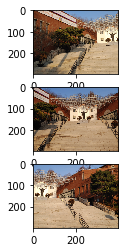

In [3]:
#이미지값을 400으로 크기조정
imageA = cv2.imread("./images/01.jpg")
imageB = cv2.imread("./images/02.jpg")
imageC = cv2.imread("./images/03.jpg")

imageA = imutils.resize(imageA, width=400 ,height=200)
imageB = imutils.resize(imageB, width=400 ,height=200)
imageC = imutils.resize(imageC, width=400 ,height=200)

f, axarr = plt.subplots(3)
axarr[0].imshow(cv2.cvtColor(imageA, cv2.COLOR_BGR2RGB))
axarr[1].imshow(cv2.cvtColor(imageB, cv2.COLOR_BGR2RGB))
axarr[2].imshow(cv2.cvtColor(imageC, cv2.COLOR_BGR2RGB))


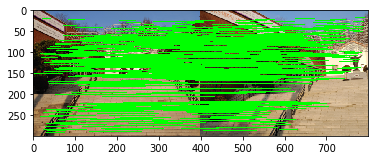

In [4]:
#이미지 좌 중 우 중에서 좌+중 으로 stitching후 출력
stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

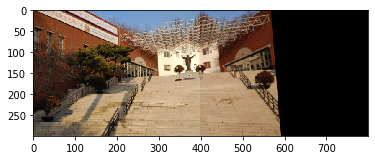

In [5]:
#결과값
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

569
569


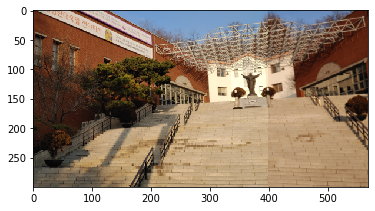

In [6]:
#stitching 된 이미지 우측부분에 cropping되지않은 검은색부분이있기에 
#우측이미지를 합성하기위해서 검은색부분까지의 거리를 계산해내어 cropping 작업실행

i=0
for i in range(result.shape[1]):
    b,g,r = result[1,i]
    if b==0 and g==0 and r==0:
        crop_width = i
        print(crop_width)
        break
print(crop_width)

crop_img = result[0:result.shape[0], 0:crop_width]

plt.imshow(cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB))


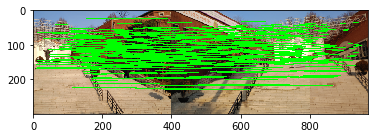

In [7]:
#cropping된 이미지와 나머지 우측이미지를 stitching

(result_fi, vis_fi) = stitcher.stitch([crop_img, imageC], showMatches=True)


plt.imshow(cv2.cvtColor(vis_fi, cv2.COLOR_BGR2RGB))


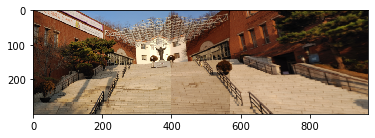

In [8]:
plt.imshow(cv2.cvtColor(result_fi, cv2.COLOR_BGR2RGB))
#결과값